#Investments: Quantitative Tools Project
*Building a Trading Strategy by using Neural Networks*

Berna 19-748-979  \
Lorena Tassone, 18-700-237\
Naomi Huser, 17-056-201



Using LSTMetended for all signals

## Setup
loads the dataframes market_data and news_sentiment_data

In [5]:
import pandas as pd
from google.colab import drive
import datetime as dt
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# set seed values for reproducibility
def set_seed(seed):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)
  keras.backend.clear_session()
  tf.keras.utils.set_random_seed(42)

set_seed(42)

In [6]:
drive.mount("/content/drive")

# Reading in data
market_data = pd.read_excel('/content/drive/MyDrive/IQTProject/data/market_data.xlsx')
news_sentiment_data = pd.read_excel('/content/drive/MyDrive/IQTProject/data/news_sentiment_data.xlsx', sheet_name=1)
vix_data = pd.read_excel('/content/drive/MyDrive/IQTProject/data/VIX.xlsx')

Mounted at /content/drive


In [7]:
# convert the 'Date' column to datetime format
market_data['Date'] = pd.to_datetime(market_data['Date'])

# set the 'Date' column as the index
market_data.set_index('Date', inplace=True)

# Add Price/Earnings Growth Variable
market_data['PEg'] = market_data['PE'].pct_change()

# Add Revenue Growth Variable
market_data['RVg'] = market_data['RV'].pct_change()

# Add GDP Growth Rate
market_data['GDPg'] = market_data['GDP'].pct_change()

# Add Earnings Growth Rate
market_data['EDg'] = market_data['ED'].pct_change()

# Add CAPE Growth Variable
market_data['CAPEg'] = market_data['CAPE'].pct_change()
market_data

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_TY,_OIL,_MKT,_VA,_GR,PEg,RVg,GDPg,EDg,CAPEg
Date,,,,,,,,,,,,,,,,,,,,,
1988-04-10,0.020585,12.9,14.469,3.60,-0.083,118.0,6.020,-1.061,7.459,8.484,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
1988-04-17,0.020585,12.4,13.960,3.75,-0.078,121.0,5.880,-0.760,7.582,8.737,...,-0.014859,0.088270,-0.034363,0.000000,0.000000,-0.038760,0.000290,0.000000,0.000147,-0.035179
1988-04-24,0.020585,12.4,13.950,3.75,-0.051,123.0,5.830,-0.760,7.618,8.773,...,-0.000663,-0.003811,0.000124,0.000000,0.000000,0.000000,-0.000572,0.000000,-0.000301,-0.000716
1988-05-01,0.020439,12.5,14.036,3.75,-0.054,124.2,5.980,-0.760,7.728,8.873,...,-0.004820,-0.016393,0.007017,0.021467,-0.002973,0.008065,-0.005239,0.000000,-0.004541,0.006165
1988-05-08,0.022931,12.3,13.761,3.82,-0.079,118.4,6.290,-0.760,7.885,8.990,...,-0.005823,-0.014444,-0.015360,0.000000,0.000000,-0.016000,0.014103,0.000000,0.009572,-0.019592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23,0.036687,22.7,27.416,1.63,0.367,120.8,5.116,2.308,4.185,3.573,...,-0.003991,-0.147843,-0.000739,0.000073,-0.002121,0.000000,-0.000001,0.000000,-0.001471,-0.001820
2023-04-30,0.036510,22.8,27.563,1.62,0.384,122.5,5.100,2.308,4.094,3.429,...,0.012543,0.091439,0.006444,-0.000677,0.015367,0.004405,0.000922,0.000000,0.048523,0.005362
2023-05-07,0.036326,22.3,27.342,1.65,0.386,130.2,5.251,2.308,3.983,3.436,...,0.000053,-0.073746,-0.006912,-0.015942,0.000390,-0.021930,-0.005285,0.000000,0.059100,-0.008018


In [8]:
# convert the 'Date' column to datetime format
news_sentiment_data['date'] = pd.to_datetime(news_sentiment_data['date'])

# set the 'Date' column as the index
news_sentiment_data.set_index('date', inplace=True)

news_sentiment_data

,News Sentiment
date,
1980-01-01,-0.038498
1980-01-02,-0.107768
1980-01-03,-0.091131
1980-01-05,-0.069345
1980-01-06,-0.091695
...,...
2023-05-17,-0.358352
2023-05-18,-0.359043
2023-05-19,-0.351221


In [9]:
# convert the 'Date' column to datetime format
vix_data['Date'] = pd.to_datetime(vix_data['Date'])
# vix_data = vix_data.drop('Return', axis=1)
vix_data = vix_data.drop('Close', axis=1)


# set the 'Date' column as the index
vix_data.set_index('Date', inplace=True)

vix_data

,Return
Date,
1990-02-01,NaN
1990-02-02,-0.022115
1990-02-05,0.009046
1990-02-06,0.006112
1990-02-07,-0.016201
...,...
2023-06-14,-0.049966
2023-06-15,0.044669
2023-06-16,-0.066207


In [10]:
# Create weekly average sentiment
news_sentiment_weekly = news_sentiment_data.resample('W').mean()

# Move Friday close VIX price to Sunday
# Since we have daily VIX close price, we assign the close price of each friday to sunday to have matching dates with our main dataset
new_index = vix_data.index + pd.DateOffset(days=2)
vix_data.index = new_index

# Merging datasets
dataset = market_data.merge(news_sentiment_weekly, how='left', left_index=True, right_index=True)
dataset.rename(columns={'News Sentiment':'NewsSent'}, inplace=True)
dataset = dataset.merge(vix_data, how='left', left_index=True, right_index=True)
dataset.rename(columns={'Return':'VIX'}, inplace=True)
dataset

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_MKT,_VA,_GR,PEg,RVg,GDPg,EDg,CAPEg,NewsSent,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1988-04-10,0.020585,12.9,14.469,3.60,-0.083,118.0,6.020,-1.061,7.459,8.484,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-0.115132,NaN
1988-04-17,0.020585,12.4,13.960,3.75,-0.078,121.0,5.880,-0.760,7.582,8.737,...,-0.034363,0.000000,0.000000,-0.038760,0.000290,0.000000,0.000147,-0.035179,-0.053699,NaN
1988-04-24,0.020585,12.4,13.950,3.75,-0.051,123.0,5.830,-0.760,7.618,8.773,...,0.000124,0.000000,0.000000,0.000000,-0.000572,0.000000,-0.000301,-0.000716,-0.023634,NaN
1988-05-01,0.020439,12.5,14.036,3.75,-0.054,124.2,5.980,-0.760,7.728,8.873,...,0.007017,0.021467,-0.002973,0.008065,-0.005239,0.000000,-0.004541,0.006165,-0.004594,NaN
1988-05-08,0.022931,12.3,13.761,3.82,-0.079,118.4,6.290,-0.760,7.885,8.990,...,-0.015360,0.000000,0.000000,-0.016000,0.014103,0.000000,0.009572,-0.019592,0.062477,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23,0.036687,22.7,27.416,1.63,0.367,120.8,5.116,2.308,4.185,3.573,...,-0.000739,0.000073,-0.002121,0.000000,-0.000001,0.000000,-0.001471,-0.001820,-0.174929,-0.023296
2023-04-30,0.036510,22.8,27.563,1.62,0.384,122.5,5.100,2.308,4.094,3.429,...,0.006444,-0.000677,0.015367,0.004405,0.000922,0.000000,0.048523,0.005362,-0.217118,-0.073400
2023-05-07,0.036326,22.3,27.342,1.65,0.386,130.2,5.251,2.308,3.983,3.436,...,-0.006912,-0.015942,0.000390,-0.021930,-0.005285,0.000000,0.059100,-0.008018,-0.275932,-0.144350


In [11]:
# VIX Price (Return) only starting 1990-02-04 (1990-02-11) available
dataset = dataset.loc['1990-02-11':,:]
dataset = dataset.interpolate()
dataset

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_MKT,_VA,_GR,PEg,RVg,GDPg,EDg,CAPEg,NewsSent,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-11,0.048441,13.9,16.293,3.42,0.360,105.6,7.908,2.039,8.245,8.330,...,0.010994,0.000000,0.000000,0.007246,0.017190,0.000000,0.022236,0.010168,0.067334,-0.003366
1990-02-18,0.048441,13.9,16.221,3.44,0.347,94.6,7.844,2.337,8.360,8.467,...,-0.003554,0.000000,0.000000,0.000000,-0.000117,0.028272,0.000105,-0.004419,0.090295,0.054287
1990-02-25,0.048441,13.5,15.791,3.54,0.356,107.2,7.825,2.337,8.441,8.586,...,-0.025695,0.000000,0.000000,-0.028777,-0.000001,0.000000,-0.000006,-0.026509,0.030421,0.051020
1990-03-04,0.048441,13.9,16.184,3.44,0.357,106.5,7.929,2.337,8.486,8.546,...,0.031369,0.025439,0.004710,0.029630,-0.000499,0.000000,-0.000332,0.024888,0.045941,-0.025571
1990-03-11,0.048441,14.0,16.334,3.41,0.328,106.4,8.147,2.337,8.672,8.636,...,0.010115,0.000000,0.000000,0.007194,0.000504,0.000000,0.000326,0.009268,0.065969,0.028369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23,0.036687,22.7,27.416,1.63,0.367,120.8,5.116,2.308,4.185,3.573,...,-0.000739,0.000073,-0.002121,0.000000,-0.000001,0.000000,-0.001471,-0.001820,-0.174929,-0.023296
2023-04-30,0.036510,22.8,27.563,1.62,0.384,122.5,5.100,2.308,4.094,3.429,...,0.006444,-0.000677,0.015367,0.004405,0.000922,0.000000,0.048523,0.005362,-0.217118,-0.073400
2023-05-07,0.036326,22.3,27.342,1.65,0.386,130.2,5.251,2.308,3.983,3.436,...,-0.006912,-0.015942,0.000390,-0.021930,-0.005285,0.000000,0.059100,-0.008018,-0.275932,-0.144350


## Analysis

### Correlation Analysis


In [12]:
correlation_matrix = dataset.corr()
mkt_corr = correlation_matrix['_MKT'].sort_values()
mkt_corr

VIX        -0.266064
_DXY       -0.148432
_TY        -0.146189
MOV        -0.103828
YSS        -0.066418
RV         -0.046144
DY         -0.035101
CPI        -0.023953
NYF        -0.020479
ED         -0.016167
DIL        -0.012119
GDP        -0.011977
NewsSent   -0.005938
STP        -0.005696
RR         -0.001617
CF          0.002083
Y10         0.002508
EMP         0.002818
Y02         0.004386
MG          0.008089
IR          0.010767
RVg         0.012630
EDg         0.013100
_AU         0.023962
M2          0.025670
Rho         0.031578
UN          0.036523
CAPE        0.043411
GDPg        0.047024
PE          0.057996
_OIL        0.151533
_LCP        0.291897
_GR         0.747979
_VA         0.768276
PEg         0.941033
CAPEg       0.996661
_MKT        1.000000
Name: _MKT, dtype: float64

## Strategy Training & Testing


### Window Generator, Autoencoder & Direcitonal Accuracy

In [13]:
# Defining Window Generator and Autoencoder

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, input_columns=None, label_columns=None, all_columns=None):
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.train_label_indices = {name: i for i, name in enumerate(all_columns)}

        # ...and the input column indices
        self.input_columns = input_columns
        if input_columns is not None:
            self.input_columns_indices = {name: i for i, name in enumerate(input_columns)}
        self.train_input_indices = {name: i for i, name in enumerate(all_columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.input_columns is not None:
            inputs = tf.stack([inputs[:, :, self.train_input_indices[name]] for name in self.input_columns], axis=-1)
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.train_label_indices[name]] for name in self.label_columns], axis=-1)
        return inputs, labels

    def make_dataset(self, data, shuffle=False, batchsize=500, ):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None,
                                                                  sequence_length=self.total_window_size,
                                                                  sequence_stride=1, sampling_rate=1, shuffle=shuffle,
                                                                  batch_size=batchsize)
        ds = ds.map(self.split_window)
        return ds


class Autoencoder(tf.keras.models.Model):
    def __init__(self, num_timesteps, num_inputs, num_hidden, kernel_size, pooling):
        super(Autoencoder, self).__init__()
        self.num = num_timesteps
        self.lb = kernel_size
        self.pooling = pooling

        encoder_input = tf.keras.Input(shape=(num_timesteps, num_inputs), name="input")
        x = tf.keras.layers.Conv1D(filters=num_hidden, kernel_size=kernel_size, activation=None, use_bias=True,
                                   padding='causal')(encoder_input)
        x = tf.keras.layers.MaxPooling1D(self.pooling, strides=self.pooling, padding='same')(x)
        self.encoder = tf.keras.Model(inputs=encoder_input, outputs=x)
        decoder_input = tf.keras.Input(shape=(int(num_timesteps / self.pooling), num_hidden))
        y = tf.keras.layers.Conv1DTranspose(filters=num_inputs, kernel_size=kernel_size, strides=self.pooling,
                                            activation=None, use_bias=True, padding='same')(decoder_input)
        self.decoder = tf.keras.Model(inputs=decoder_input, outputs=y)

    def call(self, input):
        u = self.encoder(input)
        decoded = self.decoder(u)
        return decoded

class Autoencoder_New(tf.keras.models.Model):
    def __init__(self, num_inputs, num_hidden, kernel_size, pooling):
        super(Autoencoder, self).__init__()
        self.lb = kernel_size
        self.pooling = pooling

        encoder_input = tf.keras.Input(shape=(num_inputs,), name="input")
        x = tf.keras.layers.Reshape((num_inputs, 1))(encoder_input)
        x = tf.keras.layers.Conv1D(filters=num_hidden, kernel_size=kernel_size, activation=None, use_bias=True,
                                   padding='causal')(x)
        x = tf.keras.layers.MaxPooling1D(self.pooling, strides=self.pooling, padding='same')(x)
        self.encoder = tf.keras.Model(inputs=encoder_input, outputs=x)
        decoder_input = tf.keras.Input(shape=(int(num_inputs / self.pooling), num_hidden))
        y = tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=kernel_size, strides=self.pooling,
                                            activation=None, use_bias=True, padding='same')(decoder_input)
        y = tf.keras.layers.Reshape((int(num_inputs / self.pooling),))(y)
        self.decoder = tf.keras.Model(inputs=decoder_input, outputs=y)

    def call(self, input):
        u = self.encoder(input)
        decoded = self.decoder(u)
        return decoded

def directional_accuracy(y_true, y_pred):
    """
    Accuracy based on whether correct direction is predicted
    """
    y_true_direction = tf.sign(y_true[1:] - y_true[:-1])
    y_pred_direction = tf.sign(y_pred[1:] - y_pred[:-1])
    correct_predictions = tf.reduce_mean(tf.cast(tf.equal(y_true_direction, y_pred_direction), dtype=tf.float32))
    return correct_predictions

### Setup training

In [14]:
config = tf.compat.v1.ConfigProto(device_count = {'GPU': 1 , 'CPU': 4} )
sess = tf.compat.v1.Session(config=config)
keras.backend.set_session(sess)

In [15]:
### Preparing Data

# do train test split 80/20
train = 0.8
test = 1-train
n = len(dataset)
df1 = dataset[0:int(train*n)]
df2 = dataset[int(train*n):]

# scale data (all have zero mean and unit variance)
# subtracting the mean and dividing by the standard deviation
mm_scaler = preprocessing.StandardScaler()
df1m = mm_scaler.fit_transform(df1) # learn scaling parameters from df1
df2m = mm_scaler.transform(df2) # apply on df2

# convert np array back to pandas df
train_df = pd.DataFrame(df1m, index=df1.index, columns=df1.columns)
test_df = pd.DataFrame(df2m, index=df2.index, columns=df2.columns)

train_df

,EMP,PE,CAPE,DY,Rho,MOV,IR,RR,Y02,Y10,...,_MKT,_VA,_GR,PEg,RVg,GDPg,EDg,CAPEg,NewsSent,VIX
Date,,,,,,,,,,,,,,,,,,,,,
1990-02-11,-0.035020,-1.488247,-1.200733,2.476544,0.995717,0.331149,2.160298,1.219734,2.004960,1.910567,...,0.394531,-0.084630,-0.087662,0.283155,-0.022843,0.005010,0.064505,0.431463,0.089486,0.055582
1990-02-18,-0.035020,-1.488247,-1.211562,2.513931,0.964620,-0.092151,2.132818,1.395541,2.053347,1.983517,...,-0.254495,-0.084630,-0.087662,-0.025541,-0.030744,0.049398,0.019840,-0.221897,0.213197,0.908838
1990-02-25,-0.035020,-1.587153,-1.276234,2.700867,0.986148,0.392720,2.124660,1.395541,2.087429,2.046883,...,-1.242339,-0.084630,-0.087662,-1.251441,-0.030691,0.005010,0.019616,-1.211305,-0.109389,0.860489
1990-03-04,-0.035020,-1.488247,-1.217127,2.513931,0.988540,0.365783,2.169315,1.395541,2.106363,2.025583,...,1.303586,1.018590,0.107124,1.236682,-0.030918,0.005010,0.018960,1.090758,-0.025772,-0.273053
1990-03-11,-0.035020,-1.463521,-1.194567,2.457850,0.919171,0.361935,2.262919,1.395541,2.184624,2.073507,...,0.355318,-0.084630,-0.087662,0.280934,-0.030460,0.005010,0.020287,0.391170,0.082134,0.525247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-21,0.305847,0.539317,0.036313,0.083765,-0.915532,-1.238911,-1.102530,-0.902937,-1.149483,-1.684219,...,-0.123088,0.035543,-0.167453,-0.025541,-0.265368,0.921164,-0.045203,-0.082348,0.593069,-0.011142
2016-08-28,0.305847,0.489864,0.010293,0.121152,-0.898788,-0.992627,-1.094801,-0.902937,-1.111193,-1.655998,...,-0.380205,-0.327743,-0.385829,-0.411062,-0.031112,0.005010,0.023069,-0.340008,0.707422,0.127109
2016-09-04,0.059451,0.539317,0.026537,0.083765,-0.889219,-1.173492,-1.096948,-0.902937,-1.128024,-1.675167,...,0.240298,0.279486,0.064767,0.363500,0.016377,0.005010,0.027067,0.174734,0.528871,-1.541481


### Models

In [16]:
### Set-up
from tensorflow.keras import regularizers

# def create_cnn(ks, lb, lw):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=ks, activation='relu', use_bias=False))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=ks, activation='relu', use_bias=False))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=lb-2*(ks-1)-(lw-1), activation=None, use_bias=False))
#     model.add(tf.keras.layers.Dense(units=1))

#     return model


# def create_rnn():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.SimpleRNN(2, return_sequences=False, return_state=False, activation='tanh', use_bias=True))
#     model.add(tf.keras.layers.Dense(1, activation='tanh', use_bias=True))

#     return model

# def create_lstm_simple():
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.LSTM(2, return_sequences=False, return_state=False, activation='tanh', use_bias=True))
#     model.add(tf.keras.layers.Dense(1, activation='tanh', use_bias=True))

    # return model


def create_lstm_extended(window_size=2, dropout=0.2):
  # BiLSTM (bidirectional LSTM) with dropout
    model = tf.keras.Sequential()
    # model.add(tf.keras.layers.LSTM(window_size, return_sequences=True, input_shape=(window_size, x_train.shape[-1]), return_state=False, activation='tanh', use_bias=True))
    model.add(tf.keras.layers.LSTM(window_size, return_sequences=True, return_state=False, activation='tanh', use_bias=True))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size * 2, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size, return_sequences=False)))
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('linear'))
    return model


# def create_cnn_no_regularization(ks, lb, lw, dropout=0.2):
#   # CNN model + more layers; dropout
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=ks, activation='relu', use_bias=False))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=ks, activation='relu', use_bias=False))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=lb-2*(ks-1)-(lw-1), activation=None))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Dropout(0.2))
#     # model.add(tf.keras.layers.BatchNormalization()) # Batch Normalization Layer
#     model.add(tf.keras.layers.Dense(units=16, activation='relu'))
#     model.add(tf.keras.layers.Dense(units=1))

#     return model

# def create_cnn_extended(ks, lb, lw, dropout=0.3, regularization=0.01):
#   # CNN model + more layers; dropout + regularization
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=ks, activation='relu', use_bias=False, kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=ks, activation='relu', use_bias=False, kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=lb-2*(ks-1)-(lw-1), activation=None, use_bias=False, kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Dropout(dropout))
#     # model.add(tf.keras.layers.BatchNormalization()) # Batch Normalization Layer
#     model.add(tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.Dense(units=1, kernel_regularizer=regularizers.l2(regularization)))

#     return model

# def create_cnn_binary(ks, lb, lw, dropout=0.3, regularization=0.01):
#     # Binary classifier CNN model + more layers; dropout + regularization
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=ks, activation='relu', use_bias=False, kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=ks, activation='relu', use_bias=False, kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=lb - 2*(ks-1) - (lw-1), activation=None, use_bias=False, kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.MaxPooling1D(pool_size=4, strides=1, padding='same'))
#     model.add(tf.keras.layers.Dropout(dropout))
#     # model.add(tf.keras.layers.BatchNormalization()) # Batch Normalization Layer
#     model.add(tf.keras.layers.Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(regularization)))
#     model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Output layer for binary classification

#     return model


### Signal 1.1: VIX and Gold


#### Window Generator

In [46]:
### Window Generator
set_seed(123)

# sliding window & look back
lf = 13
ks = 26
lw = 1
lb = 52

lf_2 = 13
ks_2 = 3
lw_2 = 1
lb_2 = 52


pooling = 1

# Defining input and target variables
inp_columns = ['NewsSent', '_AU'] # input
lab_columns = ['VIX'] # target that we want to predict
inp_columns_2 = ['_DXY', '_LCP']
lab_columns_2 = ['_AU']


window = WindowGenerator(input_width=lb, label_width=lw, shift=lf, input_columns=inp_columns, label_columns=lab_columns, all_columns=train_df.columns)
window_2 = WindowGenerator(input_width=lb_2, label_width=lw_2, shift=lf_2, input_columns=inp_columns_2, label_columns=lab_columns_2, all_columns=train_df.columns)
td = window.make_dataset(train_df, shuffle=True)
td_2 = window_2.make_dataset(train_df, shuffle=True)

# inp shape: (lb, ks, num_variables)

# cross-validation
is_data = td.take(2)
os_data = td.skip(2)
is_data_2 = td_2.take(2)
os_data_2 = td_2.skip(2)

#### Set-up and Training Model

Epoch 1/100
2/2 [==============================] - 8s 5s/step - loss: 1.3740 - mean_squared_error: 1.3740 - directional_accuracy: 0.4870 - val_loss: 0.8857 - val_mean_squared_error: 0.8857 - val_directional_accuracy: 0.5309
Epoch 2/100
2/2 [==============================] - 7s 4s/step - loss: 1.0663 - mean_squared_error: 1.0663 - directional_accuracy: 0.5080 - val_loss: 1.0089 - val_mean_squared_error: 1.0089 - val_directional_accuracy: 0.4969
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 0.9888 - mean_squared_error: 0.9888 - directional_accuracy: 0.4960 - val_loss: 0.7230 - val_mean_squared_error: 0.7230 - val_directional_accuracy: 0.5185
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 0.9535 - mean_squared_error: 0.9535 - directional_accuracy: 0.5020 - val_loss: 0.6103 - val_mean_squared_error: 0.6103 - val_directional_accuracy: 0.5216
Epoch 5/100
2/2 [==============================] - 6s 3s/step - loss: 0.9462 - mean_squared_error: 0.946

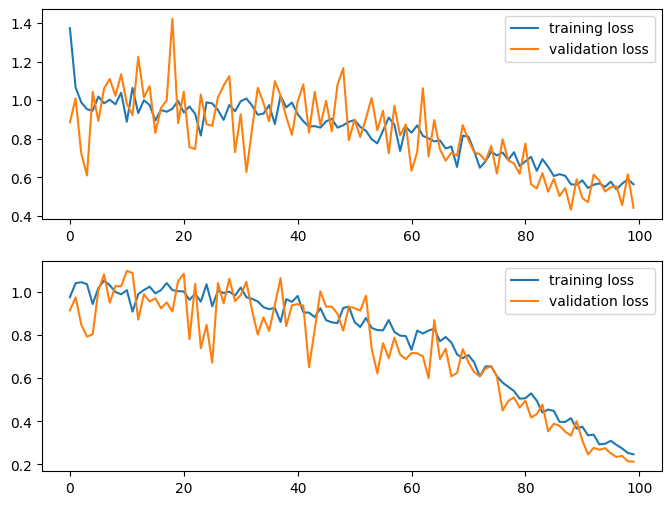

In [47]:
set_seed(123)

# Parameter
window_size = 65
batch_size = 100
epochs = 100
dropout= 0.3
regularization = 0.005
init_lr = 0.005

window_size_2 = 65
batch_size_2 = 100
epochs_2 =100
dropout_2 = 0.2
regularization_2 = 0.001
init_lr_2 = 0.005

# Models
model = create_lstm_extended(window_size, dropout)
model_2 = create_lstm_extended(window_size_2, dropout_2)

plt.figure(figsize=(8, 6))

### Training 1

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr, # initial learning rate
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model.fit(
    is_data,
    validation_data=os_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

model.summary()

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)



### Training 2


# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr_2, # initial learning rate
    decay_steps=50,
    decay_rate=0.95,
    staircase=True
    )

# model settings
model_2.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule),
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model_2.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model_2.fit(
    is_data_2,
    validation_data=os_data_2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

model_2.summary()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train_2 = window_2.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_2 = window_2.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)

#### Optimal Thresholds

In [51]:
# Compute optimal strategy thresholds

# model prediction
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))

y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

y_pred_os = model.predict(eval_test)
y_true_os = np.concatenate([y for x, y in eval_test], axis=0)
mse_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_os, y_pred_os))
y_pred_2_os = model_2.predict(eval_test_2)
y_true_2_os = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_2_os, y_pred_2_os))

y_mkt_os = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']

# min max predictions
min_1 = min(np.squeeze(y_pred[:, -1]))
min_1_os = min(np.squeeze(y_pred_os[:, -1]))
min_2 = min(np.squeeze(y_pred_2[:, -1]))
min_2_os = min(np.squeeze(y_pred_2_os[:, -1]))
max_1 = max(np.squeeze(y_pred[:, -1]))
max_1_os = max(np.squeeze(y_pred_os[:, -1]))
max_2 = max(np.squeeze(y_pred_2[:, -1]))
max_2_os = max(np.squeeze(y_pred_2_os[:, -1]))

min_1 = min(min_1, min_1_os)
max_1 = max(max_1, max_1_os)
min_2 = min(min_2, min_2_os)
max_2 = max(max_2, max_2_os)

# test for range of thresholds
t1 = np.arange(min_1, max_1, 0.02)
t2 = np.arange(min_2, max_2, 0.02)

ir_is_max = 0
ir_os_max = 0
sum_ir_max = ir_is_max+ir_os_max
t1_max = 0
t2_max = 0



for threshold_1 in t1:
  for threshold_2 in t2:
    threshold_1 = np.round(threshold_1, 2)
    threshold_2 = np.round(threshold_2, 2)

    # Market
    y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

    # Strategy IS
    pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0)
    pos_A_2 = np.where(np.squeeze(y_pred_2[lb+lf-lb_2-lf_2:, -1]) > threshold_2, 1, 0)
    pos = pos_A + pos_A_2
    pos = np.where(pos < 1, 0, 1)

    pnl1 = pos[1:] * y_mkt[:-1]
    pnl2 = pos[2:] * y_mkt[:-2]

    # Information Ratio
    tmp_ir = pnl1 - y_mkt[:-1]
    ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


    ############## OOS ##############

    # Market
    y_mkt = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']

    # Strategy OOS
    pos_A = np.where(np.squeeze(y_pred_os[:, -1]) > threshold_1, 1, 0)
    pos_A_2 = np.where(np.squeeze(y_pred_2_os[lb+lf-lb_2-lf_2:, -1]) > threshold_2, 1, 0)
    pos = pos_A + pos_A_2
    pos = np.where(pos < 1, 0, 1)

    pnl1 = pos[1:] * y_mkt_os[:-1]
    pnl2 = pos[2:] * y_mkt_os[:-2]

    # Information Ratio
    tmp_ir = pnl1 - y_mkt_os[:-1]
    ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

    sum = ir_os+ir_is

    if sum > 0 and sum > sum_ir_max and ir_is > ir_is_max:
      ir_is_max = ir_is
      ir_os_max = ir_os
      sum_ir_max = sum
      t1_max = threshold_1
      t2_max = threshold_2

print(ir_is_max)
print(ir_os_max)
print(t1_max)
print(t2_max)

1/1 [==============================] - 1s 766ms/step


<ipython-input-51-930f024f4c6d>:68: RuntimeWarning: invalid value encountered in double_scalars
  ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)
<ipython-input-51-930f024f4c6d>:87: RuntimeWarning: invalid value encountered in double_scalars
  ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


0.23421114337577373
0.4387460415376798
2.17
-1.67


#### IS and OOS Strategy Performance

##### Strategy

1/1 [==============================] - 2s 2s/step
[0 0 0 ... 0 1 0]
[1 1 1 ... 1 1 1]
Sharpe Ratio IS: 0.37
1/1 [==============================] - 1s 722ms/step
Sharpe Ratio OOS: 0.53


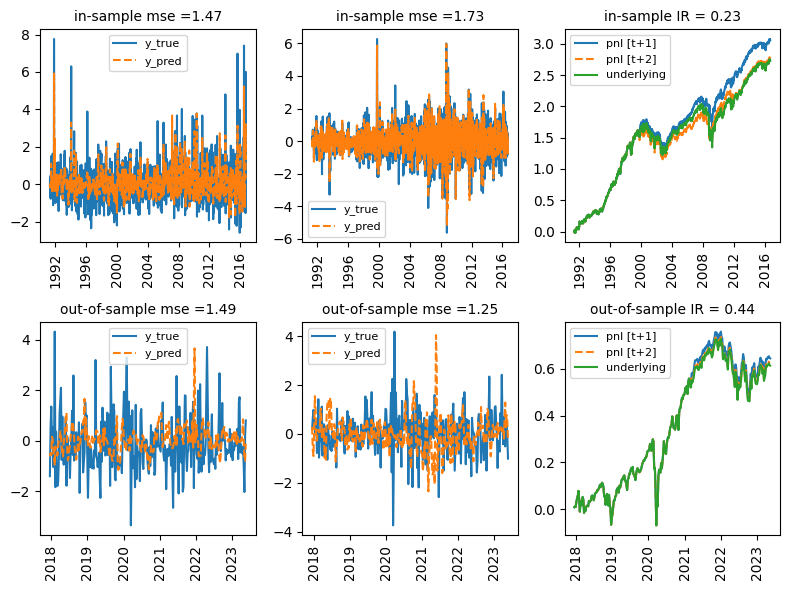

In [52]:
### Strategy Performance

plt.figure(figsize=(8,  6))

# Use best thresholds
threshold_1 = t1_max
threshold_2 = t2_max

############## IS ##############

## MSE
plt.subplot(231)
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(train_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(train_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(232)
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(train_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(train_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)


## Performance
plt.subplot(233)

# Market
y_mkt = df1.iloc[lb_2+lf_2-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[lb+lf-lb_2-lf_2:, -1]) > threshold_1, 1, 0)
print(pos_A)
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
print(pos_A_2)
pos = pos_A + pos_A_2
pos = np.where(pos < 1, 0, 1)

pnl1 = pos[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos[2:] * y_mkt[:-2]

plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df1.iloc[lb_2+lf_2-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio IS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('in-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8})
plt.xticks(rotation=90)



############## OOS ##############

## MSE
plt.subplot(234)
y_pred = model.predict(eval_test)
y_true = np.concatenate([y for x, y in eval_test], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(test_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(test_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(235)
y_pred_2 = model_2.predict(eval_test_2)
y_true_2 = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(test_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(test_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)


## Performance
plt.subplot(236)

# Market
y_mkt = df2.iloc[lb_2+lf_2-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[lb+lf-lb_2-lf_2:, -1]) > threshold_1, 1, 0)
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
pos = pos_A + pos_A_2
pos = np.where(pos < 1, 0, 1)

pnl1 = pos[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Share Ratio
rf = (df2.iloc[lb_2+lf_2-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio OOS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


plt.title('out-of-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8})
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()



##### Distribution

In [ ]:
# When do we invest in market OOS
display(pos)

# Predicted values distribution
print("Variable 1)")
y_pred_t = model.predict(eval_train)
n, bins, patches = plt.hist(np.squeeze(y_pred_t[:, -1]))
plt.show()

y_pred = model.predict(eval_test)
n, bins, patches = plt.hist(np.squeeze(y_pred[:, -1]))
plt.show()

print("Variable 2)")
y_pred_2_t = model_2.predict(eval_train_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2_t[:, -1]))
plt.show()

y_pred_2 = model_2.predict(eval_test_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2[:, -1]))
plt.show()

### Signal 1.2: VIX, Gold and Systemic Risk


#### Window Generator

In [22]:
### Window Generator -> for 2 predictors
set_seed(123)

# sliding window & look back
lf = 13
ks = 26
lw = 1
lb = 52

lf_2 = 13
ks_2 = 3
lw_2 = 1
lb_2 = 52

lf_3 = 2
ks_3 = 1
lw_3 = 1
lb_3 = 1

pooling = 1

# Defining input and target variables
inp_columns = ['NewsSent', '_AU'] # input
lab_columns = ['VIX'] # target that we want to predict
inp_columns_2 = ['_DXY', '_LCP']
lab_columns_2 = ['_AU']
inp_columns_3 = ['NewsSent', 'GDP', 'CF', 'MOV ', 'YSS']
lab_columns_3 = ['YSS']


window = WindowGenerator(input_width=lb, label_width=lw, shift=lf, input_columns=inp_columns, label_columns=lab_columns, all_columns=train_df.columns)
window_2 = WindowGenerator(input_width=lb_2, label_width=lw_2, shift=lf_2, input_columns=inp_columns_2, label_columns=lab_columns_2, all_columns=train_df.columns)
window_3 = WindowGenerator(input_width=lb_3, label_width=lw_3, shift=lf_3, input_columns=inp_columns_3, label_columns=lab_columns_3, all_columns=train_df.columns)
td = window.make_dataset(train_df, shuffle=True)
td_2 = window_2.make_dataset(train_df, shuffle=True)
td_3 = window_3.make_dataset(train_df, shuffle=True)

# inp shape: (lb, ks, num_variables)

# cross-validation
is_data = td.take(2)
os_data = td.skip(2)
is_data_2 = td_2.take(2)
os_data_2 = td_2.skip(2)
is_data_3 = td_3.take(2)
os_data_3 = td_3.skip(2)

#### Set-up and Training Model

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 1.0424 - mean_squared_error: 1.0424 - directional_accuracy: 0.4950 - val_loss: 0.8887 - val_mean_squared_error: 0.8887 - val_directional_accuracy: 0.4290
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 1.0602 - mean_squared_error: 1.0602 - directional_accuracy: 0.5060 - val_loss: 1.0096 - val_mean_squared_error: 1.0096 - val_directional_accuracy: 0.5031
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 0.9905 - mean_squared_error: 0.9905 - directional_accuracy: 0.5010 - val_loss: 0.7180 - val_mean_squared_error: 0.7180 - val_directional_accuracy: 0.4784
Epoch 4/50
2/2 [==============================] - 2s 960ms/step - loss: 0.9583 - mean_squared_error: 0.9583 - directional_accuracy: 0.4780 - val_loss: 0.6108 - val_mean_squared_error: 0.6108 - val_directional_accuracy: 0.4907
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 0.9469 - mean_squared_error: 0.9469 

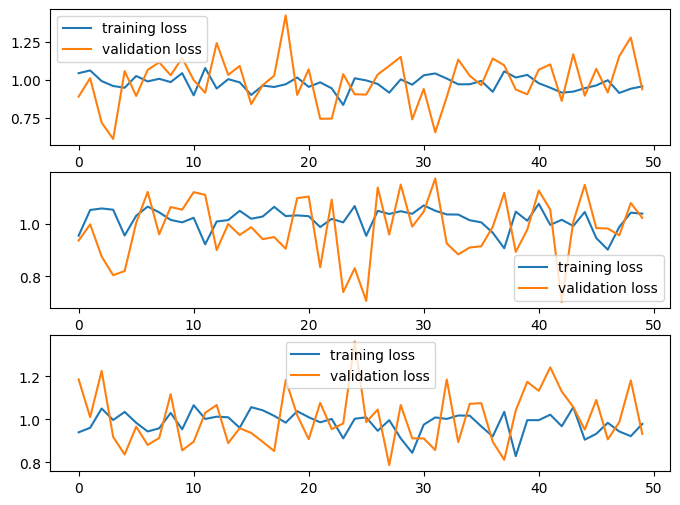

In [23]:
# Parameters
window_size = 2
batch_size = 10
epochs = 50
dropout= 0.3
regularization = 0.01
init_lr = 0.01

window_size_2 = 2
batch_size_2 = 20
epochs_2 =50
dropout_2 = 0.2
regularization_2 = 0.001
init_lr_2 = 0.001

window_size_3 = 2
batch_size_3 = 20
epochs_3 =50
dropout_3 = 0.2
regularization_3 = 0.001
init_lr_3 = 0.001

# Models
model = create_lstm_extended(window_size, dropout)
model_2 = create_lstm_extended(window_size_2, dropout_2)
model_3 = create_lstm_extended(window_size_3, dropout_3)

plt.figure(figsize=(8, 6))

### Training 1

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr, # initial learning rate
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model.fit(
    is_data,
    validation_data=os_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

model.summary()

plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)



### Training 2



# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr_3, # initial learning rate
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model_2.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model_2.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model_2.fit(
    is_data_2,
    validation_data=os_data_2,
    epochs=epochs_2,
    batch_size=batch_size_2,
    callbacks=[early_stopping]
    )

model_2.summary()

plt.subplot(3,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train_2 = window_2.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_2 = window_2.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)



### Training 3



# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr_3, # initial learning rate
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model_3.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model_3.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model_3.fit(
    is_data_3,
    validation_data=os_data_3,
    epochs=epochs_3,
    batch_size=batch_size_3,
    callbacks=[early_stopping]
    )

model_3.summary()

plt.subplot(3,1,3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train_3 = window_3.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_3 = window_3.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)

#### Optimal Thresholds


In [24]:
# Compute optimal strategy thresholds

# model prediction
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
y_pred_3 = model_3.predict(eval_train_3)
y_true_3 = np.concatenate([y for x, y in eval_train_3], axis=0)

y_pred_os = model.predict(eval_test)
y_true_os = np.concatenate([y for x, y in eval_test], axis=0)
y_pred_2_os = model_2.predict(eval_test_2)
y_true_2_os = np.concatenate([y for x, y in eval_test_2], axis=0)
y_pred_3_os = model_3.predict(eval_test_3)
y_true_3_os = np.concatenate([y for x, y in eval_test_3], axis=0)

# Market
y_mkt = df1.iloc[lb_2+lf_2-1:,:].loc[:,'_MKT']
y_mkt_os = df2.iloc[lb_2+lf_2-1:,:].loc[:,'_MKT']


# min max predictions
min_1 = min(np.squeeze(y_pred[:, -1]))
min_1_os = min(np.squeeze(y_pred_os[:, -1]))
min_2 = min(np.squeeze(y_pred_2[:, -1]))
min_2_os = min(np.squeeze(y_pred_2_os[:, -1]))
min_3 = min(np.squeeze(y_pred_3[:, -1]))
min_3_os = min(np.squeeze(y_pred_3_os[:, -1]))
max_1 = max(np.squeeze(y_pred[:, -1]))
max_1_os = max(np.squeeze(y_pred_os[:, -1]))
max_2 = max(np.squeeze(y_pred_2[:, -1]))
max_2_os = max(np.squeeze(y_pred_2_os[:, -1]))
max_3 = max(np.squeeze(y_pred_3[:, -1]))
max_3_os = max(np.squeeze(y_pred_3_os[:, -1]))

min_1 = min(min_1, min_1_os)
max_1 = max(max_1, max_1_os)
min_2 = min(min_2, min_2_os)
max_2 = max(max_2, max_2_os)
min_3 = min(min_3, min_3_os)
max_3 = max(max_3, max_3_os)


# test for range of thresholds
# t1 = np.arange(-1, 1, 0.02)
# t2 = np.arange(-1, 1, 0.02)
# t3 = np.arange(-1, 1, 0.02)

t1 = np.arange(min_1, max_1, 0.02)
t2 = np.arange(min_2, max_2, 0.02)
t3 = np.arange(min_3, max_3, 0.02)


ir_is_max = 0
ir_os_max = 0
sum_ir_max = ir_is_max+ir_os_max
t1_max = 0
t2_max = 0
t3_max = 0


for threshold_1 in t1:
  for threshold_2 in t2:
    for threshold_3 in t3:
      threshold_1 = np.round(threshold_1, 2)
      threshold_2 = np.round(threshold_2, 2)
      threshold_3 = np.round(threshold_3, 2)

      # Strategy IS
      pos_A = np.where(np.squeeze(y_pred[lb_2+lf_2-lb-lf:, -1]) > threshold_1, 1, 0)
      pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
      pos = np.where((pos_A == 1) & (pos_A_2 == 1), 1, 0) # positions where both models agree
      pos_A_3 = np.where(np.squeeze(y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0) # 0.2, best: 1
      pos_new = pos[:] + pos_A_3[:]
      pos_new = np.where(pos_new > 10, 0, 1)

      pnl1 = pos_new[1:] * y_mkt[:-1]
      pnl2 = pos_new[2:] * y_mkt[:-2]

      # Information Ratio
      tmp_ir = pnl1 - y_mkt[:-1]
      ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

      # Strategy OOS
      pos_A = np.where(np.squeeze(y_pred_os[lb_2+lf_2-lb-lf:, -1]) > threshold_1, 1, 0) # if value > threshold, set 1 else
      pos_A_2 = np.where(np.squeeze(y_pred_2_os[:, -1]) > threshold_2, 1, 0)
      pos = np.where((pos_A == 1) & (pos_A_2 == 1), 1, 0)
      pos_A_3 = np.where(np.squeeze(y_pred_3_os[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0) #  0.2, best:1
      pos_new = pos[:] + pos_A_3[:]
      pos_new = np.where(pos_new > 10, 0, 1) # if risk high, override the other decision

      pnl1 = pos_new[1:] * y_mkt_os[:-1]
      pnl2 = pos[2:] * y_mkt_os[:-2]


      # Information Ratio
      tmp_ir = pnl1 - y_mkt_os[:-1]
      ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

      sum = ir_os+ir_is

      #print("sum:"+str(sum))

      if sum > 0 and sum > sum_ir_max and ir_is > ir_is_max:
        ir_is_max = ir_is
        ir_os_max = ir_os
        sum_ir_max = sum
        t1_max = threshold_1
        t2_max = threshold_2
        t3_max = threshold_3

print("===========================")
print("ir_is_max:"+str(ir_is_max))
print("ir_os_max:"+str(ir_os_max))
print("t1_max:"+str(t1_max))
print("t2_max:"+str(t2_max))
print("t3_max:"+str(t3_max))

1/1 [==============================] - 0s 115ms/step


<ipython-input-24-0088f75947ad>:99: RuntimeWarning: invalid value encountered in double_scalars
  ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)
<ipython-input-24-0088f75947ad>:83: RuntimeWarning: invalid value encountered in double_scalars
  ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


ir_is_max:0.31219212544873337
ir_os_max:0.3327312243748105
t1_max:-0.0
t2_max:0.04
t3_max:0.07


#### IS and OOS Strategy Performance

##### Strategy

1/1 [==============================] - 0s 152ms/step
Sharpe Ratio IS: 0.37
1/1 [==============================] - 0s 82ms/step
Sharpe Ratio OOS: 0.54


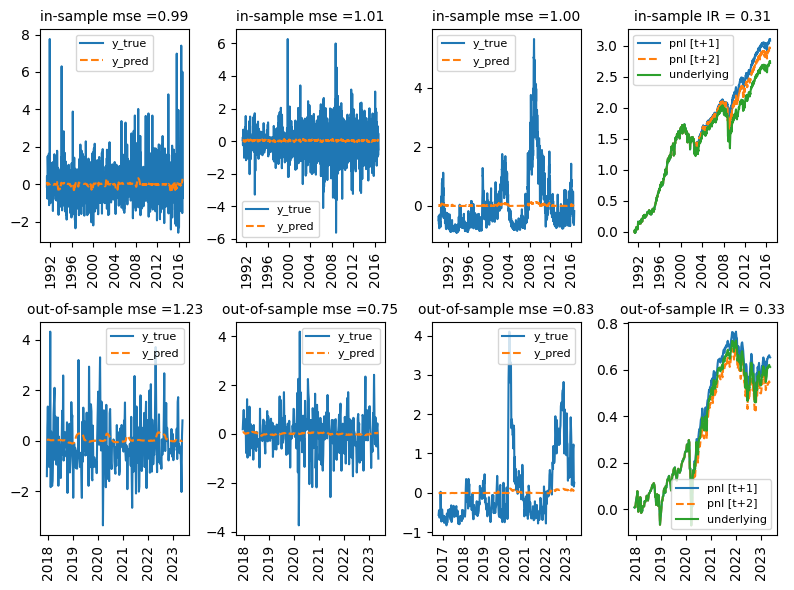

In [25]:
### Strategy Performance

plt.figure(figsize=(8, 6))

# Use best thresholds
threshold_1 = t1_max
threshold_2 = t2_max
threshold_3 = t3_max



############## IS ##############

## MSE
plt.subplot(241)
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(train_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(train_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8} )
plt.xticks(rotation=90)

plt.subplot(242)
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(train_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])  # y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1])
plt.plot(train_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8} )
plt.xticks(rotation=90)

plt.subplot(243)
y_pred_3 = model_3.predict(eval_train_3)
y_true_3 = np.concatenate([y for x, y in eval_train_3], axis=0)
mse_3 = tf.reduce_mean(tf.keras.losses.MSE(y_true_3, y_pred_3))
plt.plot(train_df.index[lb_3+lf_3-1:], y_true_3[:, -1, -1])
plt.plot(train_df.index[lb_3+lf_3-1:], y_pred_3[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse_3, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8} )
plt.xticks(rotation=90)


## Performance
plt.subplot(244)

# Market
y_mkt = df1.iloc[lb_2+lf_2-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[lb_2+lf_2-lb-lf:, -1]) > threshold_1, 1, 0)
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
pos = np.where((pos_A == 1) & (pos_A_2 == 1), 1, 0) # positions where both models agree

pos_A_3 = np.where(np.squeeze(y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0) # 0.2, best: 1
pos_new = pos[:] + pos_A_3[:]
pos_new = np.where(pos_new > 10, 0, 1)

pnl1 = pos_new[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos_new[2:] * y_mkt[:-2]

plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df1.iloc[lb_2+lf_2-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio IS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('in-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8} )
plt.xticks(rotation=90)



############## OOS ##############

## MSE
plt.subplot(245)
y_pred = model.predict(eval_test)
y_true = np.concatenate([y for x, y in eval_test], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(test_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(test_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8} )
plt.xticks(rotation=90)

plt.subplot(246)
y_pred_2 = model_2.predict(eval_test_2)
y_true_2 = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(test_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(test_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8} )
plt.xticks(rotation=90)

plt.subplot(247)
y_pred_3 = model_3.predict(eval_test_3)
y_true_3 = np.concatenate([y for x, y in eval_test_3], axis=0)
mse_3 = tf.reduce_mean(tf.keras.losses.MSE(y_true_3, y_pred_3))
plt.plot(test_df.index[lb_3+lf_3-1:], y_true_3[:, -1, -1])
plt.plot(test_df.index[lb_3+lf_3-1:], y_pred_3[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse_3, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8} )
plt.xticks(rotation=90)


## Performance
plt.subplot(248)

# Market
y_mkt = df2.iloc[lb_2+lf_2-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[lb_2+lf_2-lb-lf:, -1]) > threshold_1, 1, 0) # if value > threshold, set 1 else
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
pos = np.where((pos_A == 1) & (pos_A_2 == 1), 1, 0)

pos_A_3 = np.where(np.squeeze(y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0) #  0.2, best:1
pos_new = pos[:] + pos_A_3[:]
pos_new = np.where(pos_new > 10, 0, 1) # if risk high, override the other decision

pnl1 = pos_new[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos_new[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df2.iloc[lb_2+lf_2-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio OOS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


plt.title('out-of-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8} )
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()



##### Distribution

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

Variable 1)
1/1 [==============================] - 0s 404ms/step


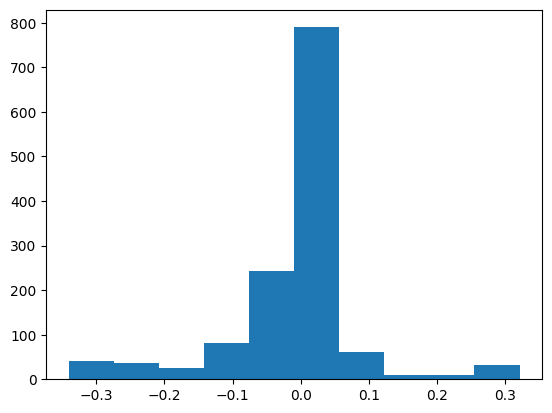

1/1 [==============================] - 0s 313ms/step


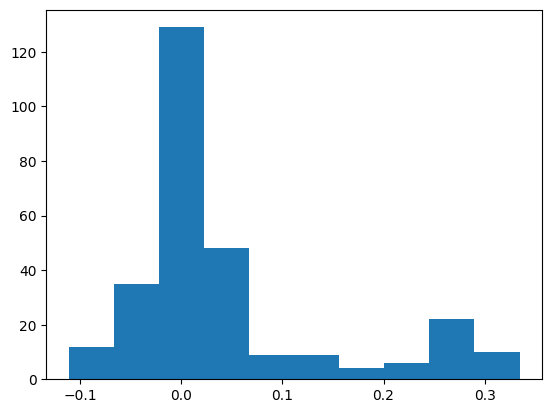

Variable 2)
1/1 [==============================] - 1s 532ms/step


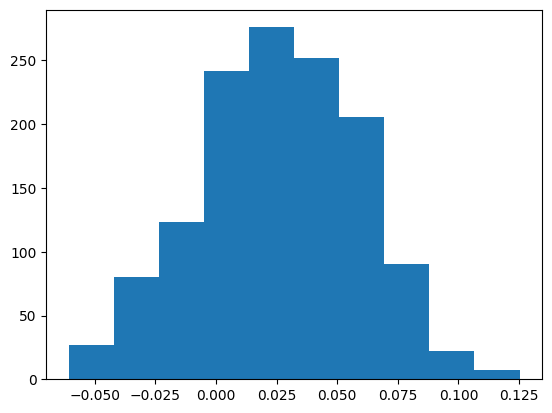

1/1 [==============================] - 0s 405ms/step


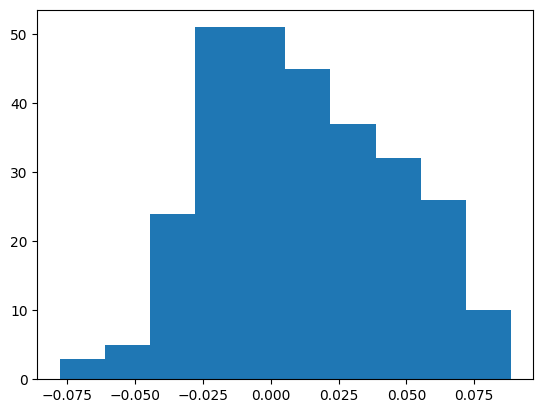

Variable 3)
1/1 [==============================] - 0s 220ms/step


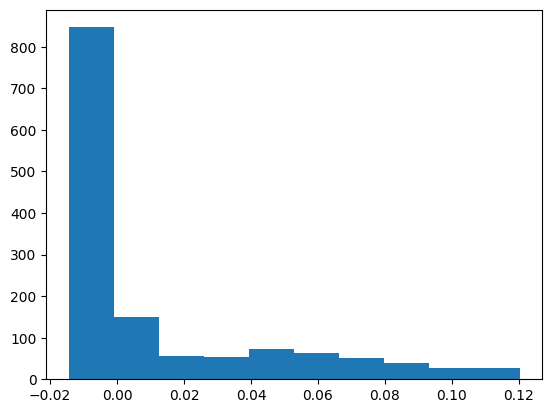

1/1 [==============================] - 0s 94ms/step


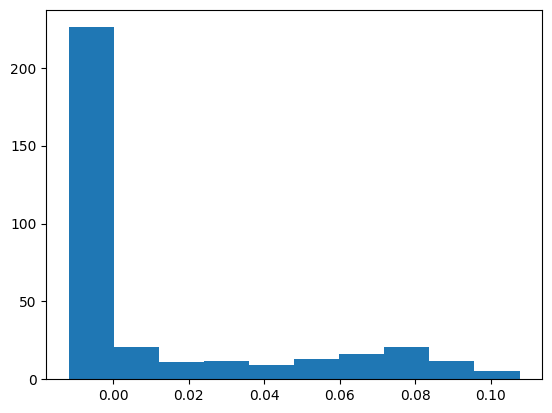

In [26]:
# When do we invest in market OOS
display(pos)

# Predicted values distribution
print("Variable 1)")
y_pred_t = model.predict(eval_train)
n, bins, patches = plt.hist(np.squeeze(y_pred_t[:, -1]))
plt.show()

y_pred = model.predict(eval_test)
n, bins, patches = plt.hist(np.squeeze(y_pred[:, -1]))
plt.show()

print("Variable 2)")
y_pred_2_t = model_2.predict(eval_train_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2_t[:, -1]))
plt.show()

y_pred_2 = model_2.predict(eval_test_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2[:, -1]))
plt.show()

print("Variable 3)")
y_pred_3_t = model_3.predict(eval_train_3)
n, bins, patches = plt.hist(np.squeeze(y_pred_3_t[:, -1]))
plt.show()

y_pred_3 = model_3.predict(eval_test_3)
n, bins, patches = plt.hist(np.squeeze(y_pred_3[:, -1]))
plt.show()

### Signal 2.1: Value and Growth


#### Window Generator

In [27]:
### Window Generator
set_seed(123)

# sliding window & look back
lf = 2
ks = 2
lw = 1
lb = 52

lf_2 = 2
ks_2 = 2
lw_2 = 1
lb_2 = 52

pooling = 1

# Defining input and target variables
inp_columns = ['DY', 'PEg'] # input
lab_columns = ['_VA'] # target that we want to predict
inp_columns_2 = ['MG', 'RVg', 'PEg']
lab_columns_2 = ['_GR']

window = WindowGenerator(input_width=lb, label_width=lw, shift=lf, input_columns=inp_columns, label_columns=lab_columns, all_columns=train_df.columns)
window_2 = WindowGenerator(input_width=lb_2, label_width=lw_2, shift=lf_2, input_columns=inp_columns_2, label_columns=lab_columns_2, all_columns=train_df.columns)
td = window.make_dataset(train_df, shuffle=True)
td_2 = window_2.make_dataset(train_df, shuffle=True)

# inp shape: (lb, ks, num_variables)

# cross-validation
is_data = td.take(2)
os_data = td.skip(2)
is_data_2 = td_2.take(2)
os_data_2 = td_2.skip(2)

#### Set-up and Training Model

Epoch 1/200
2/2 [==============================] - 4s 2s/step - loss: 1.0234 - mean_squared_error: 1.0234 - directional_accuracy: 0.4208 - val_loss: 0.9916 - val_mean_squared_error: 0.9916 - val_directional_accuracy: 0.4418
Epoch 2/200
2/2 [==============================] - 2s 1s/step - loss: 1.0510 - mean_squared_error: 1.0510 - directional_accuracy: 0.4719 - val_loss: 0.9506 - val_mean_squared_error: 0.9506 - val_directional_accuracy: 0.4657
Epoch 3/200
2/2 [==============================] - 2s 1s/step - loss: 1.0074 - mean_squared_error: 1.0074 - directional_accuracy: 0.4639 - val_loss: 1.1667 - val_mean_squared_error: 1.1667 - val_directional_accuracy: 0.4388
Epoch 4/200
2/2 [==============================] - 2s 2s/step - loss: 1.0199 - mean_squared_error: 1.0199 - directional_accuracy: 0.4609 - val_loss: 1.2987 - val_mean_squared_error: 1.2987 - val_directional_accuracy: 0.4985
Epoch 5/200
2/2 [==============================] - 2s 1s/step - loss: 1.0570 - mean_squared_error: 1.057

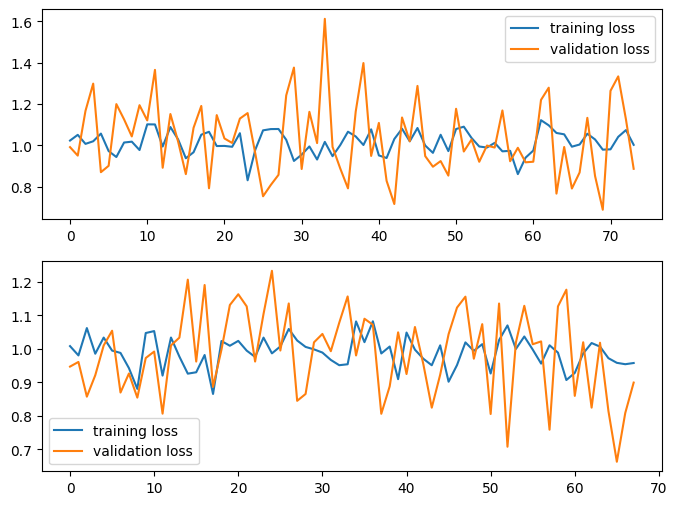

In [28]:
# Parameters
window_size = 2
dropout = 0.2
batch_size = 50
epochs = 200
init_lr = 0.01

window_size_2 = 2
dropout_2 = 0.2
batch_size_2 = 50
epochs_2 = 200
init_lr_2 = 0.01


# Models
model = create_lstm_extended(window_size, dropout)
model_2 = create_lstm_extended(window_size_2, dropout_2)

plt.figure(figsize=(8, 6))

### Training 1

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model.fit(
    is_data,
    validation_data=os_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

model.summary()

plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)



### Training 2

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr_2,
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model_2.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model_2.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model_2.fit(
    is_data_2,
    validation_data=os_data_2,
    epochs=epochs_2,
    batch_size=batch_size_2,
    callbacks=[early_stopping]
    )

model_2.summary()

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train_2 = window_2.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_2 = window_2.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)

#### Optimal Thresholds

In [29]:
# Compute optimal strategy thresholds

# model prediction
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))

y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

y_pred_os = model.predict(eval_test)
y_true_os = np.concatenate([y for x, y in eval_test], axis=0)
mse_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_os, y_pred_os))
y_pred_2_os = model_2.predict(eval_test_2)
y_true_2_os = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_2_os, y_pred_2_os))

y_mkt_os = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']


# min max predictions
min_1 = min(np.squeeze(y_pred[:, -1]))
min_1_os = min(np.squeeze(y_pred_os[:, -1]))
min_2 = min(np.squeeze(y_pred_2[:, -1]))
min_2_os = min(np.squeeze(y_pred_2_os[:, -1]))
max_1 = max(np.squeeze(y_pred[:, -1]))
max_1_os = max(np.squeeze(y_pred_os[:, -1]))
max_2 = max(np.squeeze(y_pred_2[:, -1]))
max_2_os = max(np.squeeze(y_pred_2_os[:, -1]))

min_1 = min(min_1, min_1_os)
max_1 = max(max_1, max_1_os)
min_2 = min(min_2, min_2_os)
max_2 = max(max_2, max_2_os)

# test for range of thresholds
t1 = np.arange(min_1, max_1, 0.02)
t2 = np.arange(min_2, max_2, 0.02)

ir_is_max = 0
ir_os_max = 0
sum_ir_max = ir_is_max+ir_os_max
t1_max = 0
t2_max = 0



for threshold_1 in t1:
  for threshold_2 in t2:

    # Strategy IS
    pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0)
    pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
    pos = pos_A + pos_A_2
    pos = np.where(pos <= 1, 0, 1)
    pnl1 = pos[1:] * y_mkt[:-1]

    # Information Ratio
    tmp_ir = pnl1 - y_mkt[:-1]
    ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


    # Strategy OS
    pos_A = np.where(np.squeeze(y_pred_os[:, -1]) > threshold_1, 1, 0)
    pos_A_2 = np.where(np.squeeze(y_pred_2_os[:, -1]) > threshold_2, 1, 0)
    pos = pos_A + pos_A_2
    pos = np.where(pos <= 1, 0, 1)
    pnl1 = pos[1:] * y_mkt_os[:-1]

    # Information Ratio
    tmp_ir = pnl1 - y_mkt_os[:-1]
    ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


    sum = ir_os+ir_is

    # print("sum:"+str(sum))

    if sum > 0 and sum > sum_ir_max and ir_is > ir_is_max:
      ir_is_max = ir_is
      ir_os_max = ir_os
      sum_ir_max = sum
      t1_max = threshold_1
      t2_max = threshold_2

print("===========================")
print("ir_is_max:"+str(ir_is_max))
print("ir_os_max:"+str(ir_os_max))
print("t1_max:"+str(t1_max))
print("t2_max:"+str(t2_max))


1/1 [==============================] - 0s 329ms/step


<ipython-input-29-8ffda1d97ea7>:74: RuntimeWarning: invalid value encountered in double_scalars
  ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


ir_is_max:0.39243225254148706
ir_os_max:0.47077124058012193
t1_max:-0.28705376386642456
t2_max:-0.40603920221328726


#### IS and OOS Strategy Performance

##### Strategy

1/1 [==============================] - 0s 411ms/step
Sharpe Ratio IS: 0.35
1/1 [==============================] - 0s 410ms/step
Sharpe Ratio OOS: 0.74


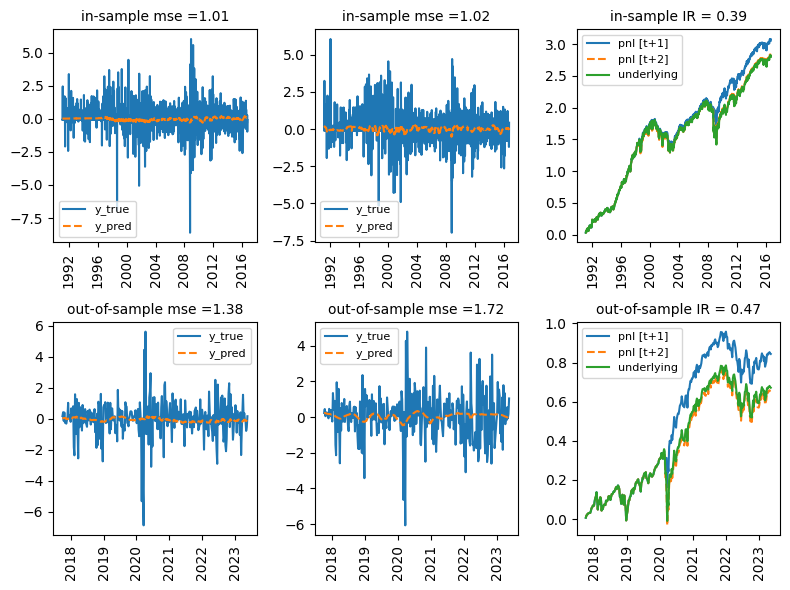

In [30]:
### Strategy Performance

# Use best thresholds
threshold_1 = t1_max
threshold_2 = t2_max

plt.figure(figsize=(8, 6))

############## IS ##############

## MSE
plt.subplot(231)
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(train_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(train_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(232)
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(train_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(train_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)


## Performance
plt.subplot(233)

# Market
y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

# Strategy A
pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0)
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
pos = pos_A + pos_A_2
pos = np.where(pos <= 1, 0, 1)
pnl1 = pos[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df1.iloc[lb+lf-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio IS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('in-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8})
plt.xticks(rotation=90)



############## OOS ##############

## MSE
plt.subplot(234)
y_pred = model.predict(eval_test)
y_true = np.concatenate([y for x, y in eval_test], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(test_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(test_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(235)
y_pred_2 = model_2.predict(eval_test_2)
y_true_2 = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(test_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(test_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)


## Performance
plt.subplot(236)

# Market
y_mkt = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0)
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
pos = pos_A + pos_A_2
pos = np.where(pos <= 1, 0, 1)
pnl1 = pos[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df2.iloc[lb+lf-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio OOS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('out-of-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8})
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()



##### Distribution

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

Variable 1)
1/1 [==============================] - 0s 410ms/step


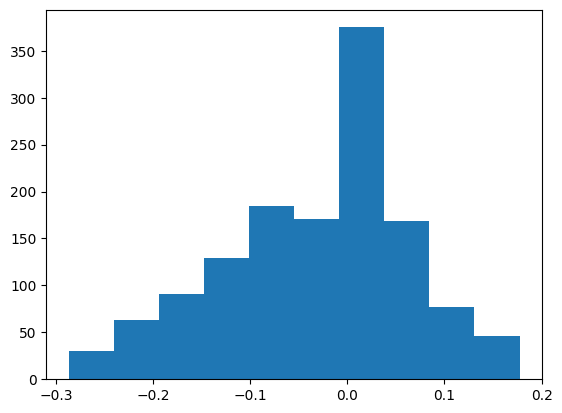

1/1 [==============================] - 0s 298ms/step


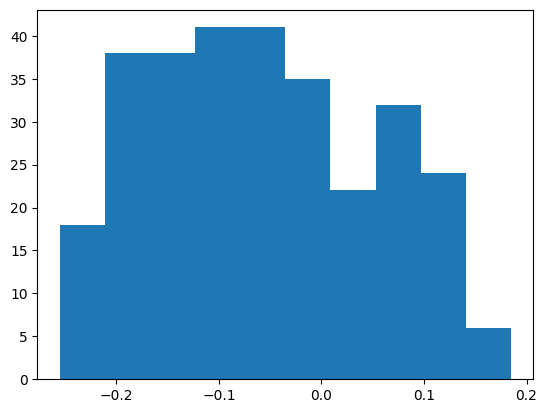

Variable 2)
1/1 [==============================] - 0s 411ms/step


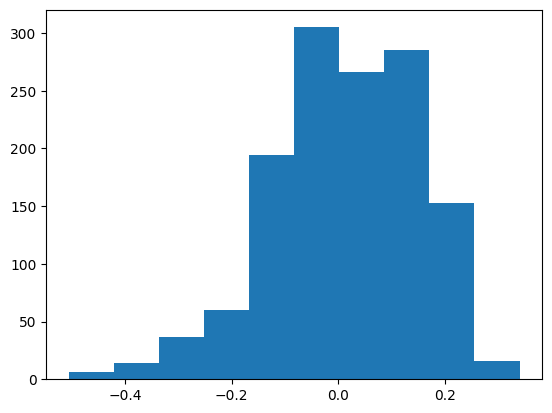

1/1 [==============================] - 0s 317ms/step


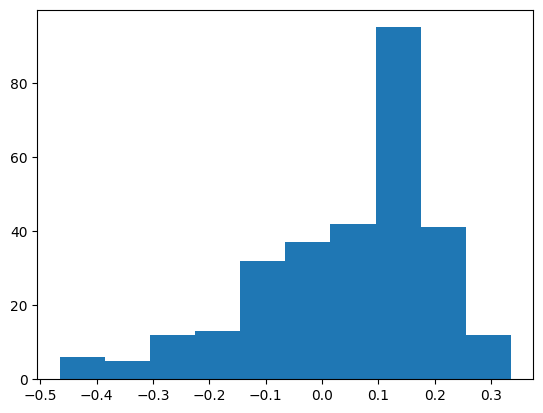

In [31]:
# When do we invest in market OOS
display(pos)

# Predicted values distribution
print("Variable 1)")
y_pred_t = model.predict(eval_train)
n, bins, patches = plt.hist(np.squeeze(y_pred_t[:, -1]))
plt.show()

y_pred = model.predict(eval_test)
n, bins, patches = plt.hist(np.squeeze(y_pred[:, -1]))
plt.show()

print("Variable 2)")
y_pred_2_t = model_2.predict(eval_train_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2_t[:, -1]))
plt.show()

y_pred_2 = model_2.predict(eval_test_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2[:, -1]))
plt.show()

### Signal 2.2: Value, Growth and Systemic Risk


#### Window Generator

In [32]:
### Window Generator
set_seed(123)

# sliding window & look back
lf = 2            # look forward (weeks), how far to predict the target variable (variables in lab_columns below)
ks = 2            # kernel size   26 (larger kernel allows more general/global patterns), 26 time steps considered at once
lw = 1            # label width (weeks), how many weeks model predicts at once -> e.g. lf=52 lw=1 -> 52 times 1 week prediction
lb = 52           # look back (weeks), how many weeks to look back to for inp variables (inp_column)

lf_2 = 2
ks_2 = 2
lw_2 = 1
lb_2 = 52

lf_3 = 2
ks_3 = 2
lw_3 = 1
lb_3 = 4

pooling = 1

# Defining input and target variables
inp_columns = ['DY', 'PEg'] # input
lab_columns = ['_VA'] # target that we want to predict
inp_columns_2 = ['MG', 'RVg', 'PEg']
lab_columns_2 = ['_GR']
inp_columns_3 = ['NewsSent', 'GDP', 'CF', 'MOV ', 'YSS']
lab_columns_3 = ['YSS']

window = WindowGenerator(input_width=lb, label_width=lw, shift=lf, input_columns=inp_columns, label_columns=lab_columns, all_columns=train_df.columns)
window_2 = WindowGenerator(input_width=lb_2, label_width=lw_2, shift=lf_2, input_columns=inp_columns_2, label_columns=lab_columns_2, all_columns=train_df.columns)
window_3 = WindowGenerator(input_width=lb_3, label_width=lw_3, shift=lf_3, input_columns=inp_columns_3, label_columns=lab_columns_3, all_columns=train_df.columns)
td = window.make_dataset(train_df, shuffle=True)
td_2 = window_2.make_dataset(train_df, shuffle=True)
td_3 = window_3.make_dataset(train_df, shuffle=True)

# inp shape: (lb, ks, num_variables)

# cross-validation
is_data = td.take(2)
os_data = td.skip(2)
is_data_2 = td_2.take(2)
os_data_2 = td_2.skip(2)
is_data_3 = td_3.take(2)
os_data_3 = td_3.skip(2)


#### Set-up and Training Model

Epoch 1/200
2/2 [==============================] - 4s 2s/step - loss: 1.0234 - mean_squared_error: 1.0234 - directional_accuracy: 0.4208 - val_loss: 0.9916 - val_mean_squared_error: 0.9916 - val_directional_accuracy: 0.4418
Epoch 2/200
2/2 [==============================] - 2s 1s/step - loss: 1.0510 - mean_squared_error: 1.0510 - directional_accuracy: 0.4719 - val_loss: 0.9506 - val_mean_squared_error: 0.9506 - val_directional_accuracy: 0.4657
Epoch 3/200
2/2 [==============================] - 2s 1s/step - loss: 1.0074 - mean_squared_error: 1.0074 - directional_accuracy: 0.4639 - val_loss: 1.1667 - val_mean_squared_error: 1.1667 - val_directional_accuracy: 0.4388
Epoch 4/200
2/2 [==============================] - 2s 1s/step - loss: 1.0199 - mean_squared_error: 1.0199 - directional_accuracy: 0.4609 - val_loss: 1.2987 - val_mean_squared_error: 1.2987 - val_directional_accuracy: 0.4985
Epoch 5/200
2/2 [==============================] - 2s 1s/step - loss: 1.0570 - mean_squared_error: 1.057

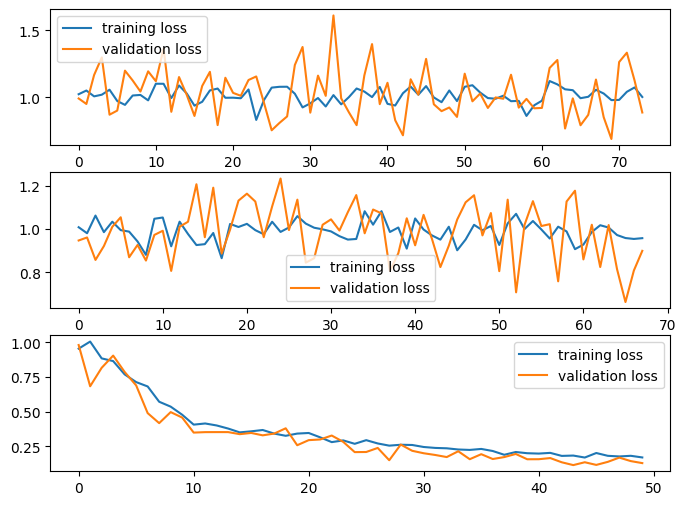

In [33]:
# Parameters
window_size = 2
dropout = 0.2
batch_size = 50
epochs = 200
init_lr = 0.01

window_size_2 = 2
dropout_2 = 0.2
batch_size_2 = 50
epochs_2 = 200
init_lr_2 = 0.01

window_size_3 = 2
dropout_3 = 0.2
batch_size_3 = 50
epochs_3 = 50
init_lr_3 = 0.01

# Models
model = create_lstm_extended(window_size, dropout)
model_2 = create_lstm_extended(window_size_2, dropout_2)
model_3 = create_lstm_extended(window_size_3, dropout_3)


plt.figure(figsize=(8, 6))


### Training 1

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model.fit(
    is_data,
    validation_data=os_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

model.summary()

plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)



### Training 2

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr_2,
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model_2.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model_2.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model_2.fit(
    is_data_2,
    validation_data=os_data_2,
    epochs=epochs_2,
    batch_size=batch_size_2,
    callbacks=[early_stopping]
    )

model_2.summary()

plt.subplot(3,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train_2 = window_2.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_2 = window_2.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)



### Training 3

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr_3,
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model_3.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model_3.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model_3.fit(
    is_data_3,
    validation_data=os_data_3,
    epochs=epochs_3,
    batch_size=batch_size_3,
    callbacks=[early_stopping]
    )

model_3.summary()

plt.subplot(3,1,3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])


eval_train_3 = window_3.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test_3 = window_3.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)

#### Optimal Thresholds

In [34]:
# Compute optimal strategy thresholds

# model prediction
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
y_pred_3 = model_3.predict(eval_train_3)
y_true_3 = np.concatenate([y for x, y in eval_train_3], axis=0)
mse_3 = tf.reduce_mean(tf.keras.losses.MSE(y_true_3, y_pred_3))

y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

y_pred_os = model.predict(eval_test)
y_true_os = np.concatenate([y for x, y in eval_test], axis=0)
mse_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_os, y_pred_os))
y_pred_2_os = model_2.predict(eval_test_2)
y_true_2_os = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_2_os, y_pred_2_os))
y_pred_3_os = model_3.predict(eval_test_3)
y_true_3_os = np.concatenate([y for x, y in eval_test_3], axis=0)
mse_3_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_3_os, y_pred_3_os))

y_mkt_os = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']


# min max predictions
min_1 = min(np.squeeze(y_pred[:, -1]))
min_1_os = min(np.squeeze(y_pred_os[:, -1]))
min_2 = min(np.squeeze(y_pred_2[:, -1]))
min_2_os = min(np.squeeze(y_pred_2_os[:, -1]))
min_3 = min(np.squeeze(y_pred_3[:, -1]))
min_3_os = min(np.squeeze(y_pred_3_os[:, -1]))
max_1 = max(np.squeeze(y_pred[:, -1]))
max_1_os = max(np.squeeze(y_pred_os[:, -1]))
max_2 = max(np.squeeze(y_pred_2[:, -1]))
max_2_os = max(np.squeeze(y_pred_2_os[:, -1]))
max_3 = max(np.squeeze(y_pred_3[:, -1]))
max_3_os = max(np.squeeze(y_pred_3_os[:, -1]))

min_1 = min(min_1, min_1_os)
max_1 = max(max_1, max_1_os)
min_2 = min(min_2, min_2_os)
max_2 = max(max_2, max_2_os)
min_3 = min(min_3, min_3_os)
max_3 = max(max_3, max_3_os)

# test for range of thresholds
t1 = np.arange(min_1, max_1, 0.2)
t2 = np.arange(min_2, max_2, 0.2)
t3 = np.arange(min_3, max_3, 0.2)


ir_is_max = 0
ir_os_max = 0
sum_ir_max = ir_is_max+ir_os_max
t1_max = 0
t2_max = 0
t3_max = 0


for threshold_1 in t1:
  for threshold_2 in t2:
    for threshold_3 in t3:

      # Strategy IS
      pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0) # -0.1
      pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0) # 0
      pos = pos_A + pos_A_2
      pos = np.where(pos == 0, 0, 1)
      pos_A_3 = np.where(np.squeeze(y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0) # 0.2, best:
      pos_new = pos[:] + pos_A_3[:]
      pos_new = np.where(pos_new > 5, 0, 1)
      pnl1 = pos_new[1:] * y_mkt[:-1]
      pnl2 = pos_new[2:] * y_mkt[:-2]

      # Information Ratio
      tmp_ir = pnl1 - y_mkt[:-1]
      ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


      # Strategy OS
      pos_A = np.where(np.squeeze(y_pred_os[:, -1]) > threshold_1, 1, 0)
      pos_A_2 = np.where(np.squeeze(y_pred_2_os[:, -1]) > threshold_2, 1, 0)
      pos = pos_A + pos_A_2
      pos = np.where(pos == 0, 0, 1)
      pos_A_3 = np.where(np.squeeze(y_pred_3_os[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0)
      pos_new = pos[:] + pos_A_3[:]
      pos_new = np.where(pos_new > 5, 0, 1)
      pnl1 = pos[1:] * y_mkt_os[:-1]
      pnl2 = pos[2:] * y_mkt_os[:-2]

      # Information Ratio
      tmp_ir = pnl1 - y_mkt_os[:-1]
      ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

      sum = ir_os+ir_is

      # print("sum:"+str(sum))

      if sum > 0 and sum > sum_ir_max and ir_is > ir_is_max:
        ir_is_max = ir_is
        ir_os_max = ir_os
        sum_ir_max = sum
        t1_max = threshold_1
        t2_max = threshold_2
        t3_max = threshold_3

print("===========================")
print("ir_is_max:"+str(ir_is_max))
print("ir_os_max:"+str(ir_os_max))
print("t1_max:"+str(t1_max))
print("t2_max:"+str(t2_max))
print("t3_max:"+str(t3_max))


1/1 [==============================] - 0s 157ms/step


<ipython-input-34-8bbd1540bbd8>:97: RuntimeWarning: invalid value encountered in double_scalars
  ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


ir_is_max:0.08905341600621486
ir_os_max:0.0026846689055839267
t1_max:-0.08705376386642455
t2_max:-0.10603920221328733
t3_max:3.3646644353866577


#### IS and OOS Strategy Performance

##### Strategy

1/1 [==============================] - 0s 168ms/step
Sharpe Ratio IS: 0.36
1/1 [==============================] - 0s 102ms/step
Sharpe Ratio OOS: 0.57


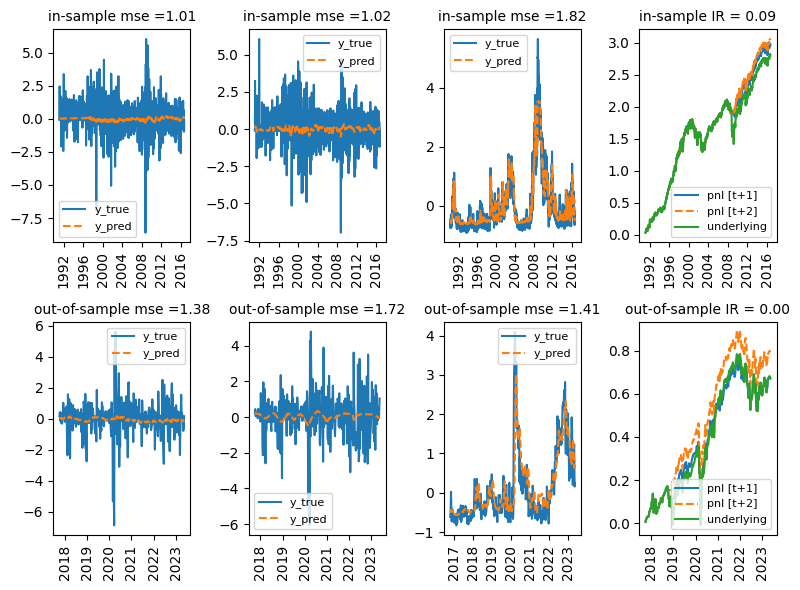

In [35]:
### Strategy Performance


# Use best thresholds
threshold_1 = t1_max  #-3
threshold_2 = t2_max  #-0.6
threshold_3 = t3_max  # 0.9

plt.figure(figsize=(8, 6))

############## IS ##############

## MSE
plt.subplot(241)
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(train_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(train_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(242)
y_pred_2 = model_2.predict(eval_train_2)
y_true_2 = np.concatenate([y for x, y in eval_train_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(train_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(train_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(243)
y_pred_3 = model_3.predict(eval_train_3)
y_true_3 = np.concatenate([y for x, y in eval_train_3], axis=0)
mse_3 = tf.reduce_mean(tf.keras.losses.MSE(y_true_3, y_pred_3))
plt.plot(train_df.index[lb_3+lf_3-1:], y_true_3[:, -1, -1])
plt.plot(train_df.index[lb_3+lf_3-1:], y_pred_3[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse_3, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)


## Performance
plt.subplot(244)

# Market
y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0) # -0.1
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0) # 0
pos = pos_A + pos_A_2
pos = np.where(pos == 0, 0, 1)

pos_A_3 = np.where(np.squeeze(y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0) # 0.2, best:
pos_new = pos[:] + pos_A_3[:]
pos_new = np.where(pos_new > 5, 0, 1)

pnl1 = pos_new[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos_new[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df1.iloc[lb+lf-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio IS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('in-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8})
plt.xticks(rotation=90)



############## OOS ##############

## MSE
plt.subplot(245)
y_pred = model.predict(eval_test)
y_true = np.concatenate([y for x, y in eval_test], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(test_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(test_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(246)
y_pred_2 = model_2.predict(eval_test_2)
y_true_2 = np.concatenate([y for x, y in eval_test_2], axis=0)
mse_2 = tf.reduce_mean(tf.keras.losses.MSE(y_true_2, y_pred_2))
plt.plot(test_df.index[lb_2+lf_2-1:], y_true_2[:, -1, -1])
plt.plot(test_df.index[lb_2+lf_2-1:], y_pred_2[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse_2, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)

plt.subplot(247)
y_pred_3 = model_3.predict(eval_test_3)
y_true_3 = np.concatenate([y for x, y in eval_test_3], axis=0)
mse_3 = tf.reduce_mean(tf.keras.losses.MSE(y_true_3, y_pred_3))
plt.plot(test_df.index[lb_3+lf_3-1:], y_true_3[:, -1, -1])
plt.plot(test_df.index[lb_3+lf_3-1:], y_pred_3[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse_3, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8})
plt.xticks(rotation=90)


## Performance
plt.subplot(248)

# Market
y_mkt = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0)
pos_A_2 = np.where(np.squeeze(y_pred_2[:, -1]) > threshold_2, 1, 0)
pos = pos_A + pos_A_2
pos = np.where(pos == 0, 0, 1)

pos_A_3 = np.where(np.squeeze(y_pred_3[lb_2+lf_2-lb_3-lf_3:, -1]) > threshold_3, 10, 0)
pos_new = pos[:] + pos_A_3[:]
pos_new = np.where(pos_new > 5, 0, 1)

pnl1 = pos[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2 = pos[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Share Ratio
rf = (df2.iloc[lb+lf-1:,:].loc[:,'_TY'])
tmp_sr = pnl1 - rf[:-1]
sr = tmp_sr.mean() / pnl1.std() * np.sqrt(52)
print("Sharpe Ratio OOS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1 - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('out-of-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8})
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()



##### Distribution

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

Variable 1
1/1 [==============================] - 0s 388ms/step


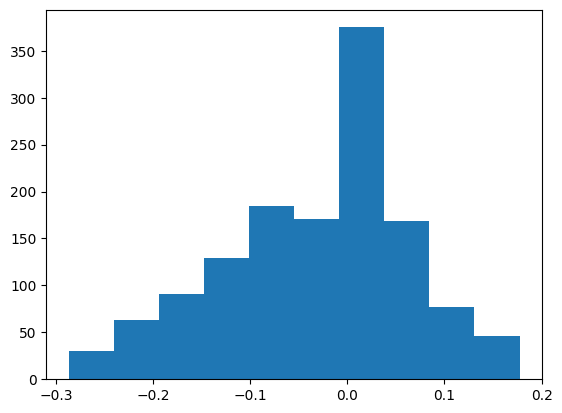

1/1 [==============================] - 0s 335ms/step


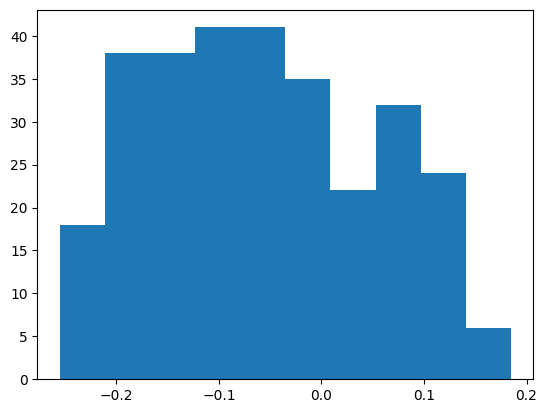

Variable 2
1/1 [==============================] - 0s 382ms/step


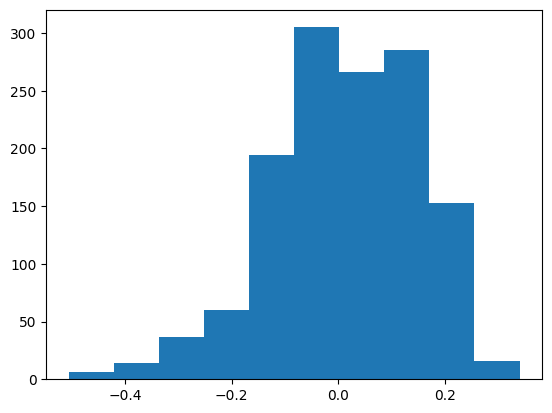

1/1 [==============================] - 0s 297ms/step


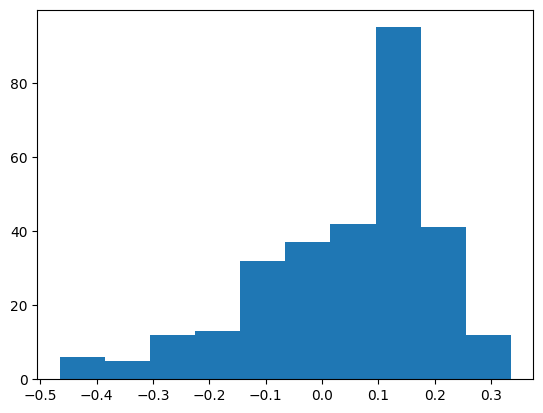

Variable 3
1/1 [==============================] - 0s 188ms/step


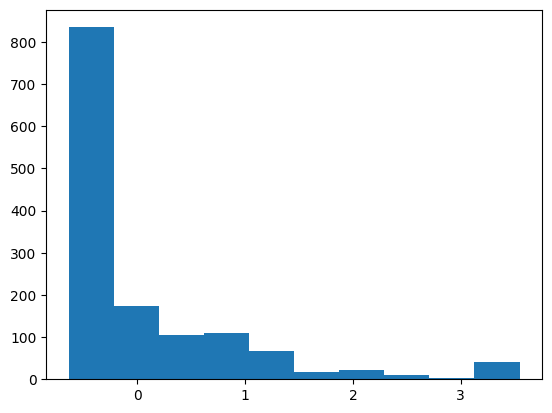

1/1 [==============================] - 0s 101ms/step


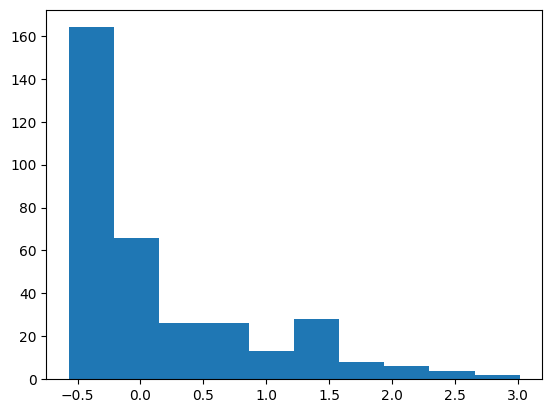

In [36]:
# When do we invest in market OOS
display(pos)

# Predicted values distribution
print("Variable 1")
y_pred = model.predict(eval_train)
n, bins, patches = plt.hist(np.squeeze(y_pred[:, -1]))
plt.show()
y_pred = model.predict(eval_test)
n, bins, patches = plt.hist(np.squeeze(y_pred[:, -1]))
plt.show()

print("Variable 2")
y_pred_2 = model_2.predict(eval_train_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2[:, -1]))
plt.show()
y_pred_2 = model_2.predict(eval_test_2)
n, bins, patches = plt.hist(np.squeeze(y_pred_2[:, -1]))
plt.show()

print("Variable 3")
y_pred_3 = model_3.predict(eval_train_3)
n, bins, patches = plt.hist(np.squeeze(y_pred_3[:, -1]))
plt.show()
y_pred_3 = model_3.predict(eval_test_3)
n, bins, patches = plt.hist(np.squeeze(y_pred_3[:, -1]))
plt.show()




### Signal 3: Cyclically Adjusted Price/Earnings

#### Window Generator


In [37]:
### Window Generator -> for 1 predictor
set_seed(123)

# sliding window & look back
lf = 35      # look forward (weeks), how far to predict the target variable (variables in lab_columns below)
ks = 26      # kernel size   26 (larger kernel allows more general/global patterns), 26 time steps considered at once
lw = 1       # label width (weeks), how many weeks model predicts at once -> e.g. lf=52 lw=1 -> 52 times 1 week prediction
lb = 78      # look back (weeks), how many weeks to look back to for inp variables (inp_column)

pooling = 1

# Defining input and target variables
inp_columns = ['MG', 'EDg'] # input
lab_columns = ['CAPEg'] # target that we want to predict

window = WindowGenerator(input_width=lb, label_width=lw, shift=lf, input_columns=inp_columns, label_columns=lab_columns, all_columns=train_df.columns)
td = window.make_dataset(train_df, shuffle=True)

# inp shape: (lb, ks, num_variables)

# cross-validation
is_data = td.take(2)
os_data = td.skip(2)



#### Set-up and Training Model

Epoch 1/50
2/2 [==============================] - 10s 5s/step - loss: 1.0397 - mean_squared_error: 1.0397 - directional_accuracy: 0.5060 - val_loss: 1.2255 - val_mean_squared_error: 1.2255 - val_directional_accuracy: 0.5326
Epoch 2/50
2/2 [==============================] - 7s 4s/step - loss: 1.0542 - mean_squared_error: 1.0542 - directional_accuracy: 0.5100 - val_loss: 1.0662 - val_mean_squared_error: 1.0662 - val_directional_accuracy: 0.5254
Epoch 3/50
2/2 [==============================] - 6s 4s/step - loss: 1.0216 - mean_squared_error: 1.0216 - directional_accuracy: 0.5230 - val_loss: 1.0946 - val_mean_squared_error: 1.0946 - val_directional_accuracy: 0.5145
Epoch 4/50
2/2 [==============================] - 7s 4s/step - loss: 1.0559 - mean_squared_error: 1.0559 - directional_accuracy: 0.5160 - val_loss: 1.0626 - val_mean_squared_error: 1.0626 - val_directional_accuracy: 0.5254
Epoch 5/50
2/2 [==============================] - 6s 4s/step - loss: 1.0126 - mean_squared_error: 1.0126 - 

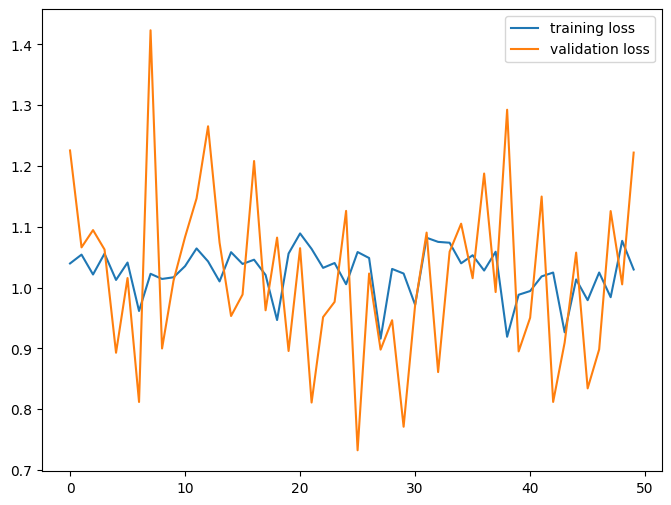

In [38]:
# Parameters
batch_size = 10
epochs = 50
dropout = 0.4
init_lr = 0.00055
window_size = 50

# Model
model = create_lstm_extended(window_size, dropout)

plt.figure(figsize=(8, 6))

### Training 1

# learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=50,
    decay_rate=0.97,
    staircase=True
    )

# model settings
model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), # optimizer=tf.optimizers.SGD(learning_rate=lr_schedule)
    metrics=[tf.metrics.MeanSquaredError(),
             directional_accuracy])
model.run_eagerly = True

# define early stopping condition
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, mode='min')

# train model
history = model.fit(
    is_data,
    validation_data=os_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
    )

model.summary()

plt.subplot(1,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])

eval_train = window.make_dataset(train_df, batchsize=train_df.shape[0], shuffle=False)
eval_test = window.make_dataset(test_df, batchsize=test_df.shape[0], shuffle=False)


#### Optimal Thresholds

In [39]:
# Compute optimal strategy thresholds

# model prediction
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))

y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

y_pred_os = model.predict(eval_test)
y_true_os = np.concatenate([y for x, y in eval_test], axis=0)
mse_os = tf.reduce_mean(tf.keras.losses.MSE(y_true_os, y_pred_os))

y_mkt_os = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']


# min max predictions
min_1 = min(np.squeeze(y_pred[:, -1]))
min_1_os = min(np.squeeze(y_pred_os[:, -1]))
max_1 = max(np.squeeze(y_pred[:, -1]))
max_1_os = max(np.squeeze(y_pred_os[:, -1]))

min_1 = min(min_1, min_1_os)
max_1 = max(max_1, max_1_os)

# test for range of thresholds
t1 = np.arange(min_1, max_1, 0.0002)

ir_is_max = 0
ir_os_max = 0
sum_ir_max = ir_is_max+ir_os_max
t1_max = 0



for threshold_1 in t1:

  # Strategy IS
  pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold_1, 1, 0)
  pnl1_A = pos_A[1:] * y_mkt[:-1]

  # Information Ratio
  tmp_ir = pnl1_A - y_mkt[:-1]
  ir_is = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

  # Strategy OS
  pos_A = np.where(np.squeeze(y_pred_os[:, -1]) > threshold_1, 1, 0)
  pnl1_A = pos_A[1:] * y_mkt_os[:-1]

  # Information Ratio
  tmp_ir = pnl1_A - y_mkt_os[:-1]
  ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

  sum = ir_os+ir_is

  # print("sum:"+str(sum))

  if sum > 0 and sum > sum_ir_max and ir_is > ir_is_max:
    ir_is_max = ir_is
    ir_os_max = ir_os
    sum_ir_max = sum
    t1_max = threshold_1

print("===========================")
print("ir_is_max:"+str(ir_is_max))
print("ir_os_max:"+str(ir_os_max))
print("t1_max:"+str(t1_max))

1/1 [==============================] - 1s 745ms/step


<ipython-input-39-09caa32f73d3>:52: RuntimeWarning: invalid value encountered in double_scalars
  ir_os = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)


ir_is_max:0.21033062957561605
ir_os_max:0.5959468257329867
t1_max:-0.13632060337068985


##### Strategy

1/1 [==============================] - 2s 2s/step
Sharpe Ratio IS: 0.33
1/1 [==============================] - 1s 737ms/step
Sharpe Ratio OOS: 0.6


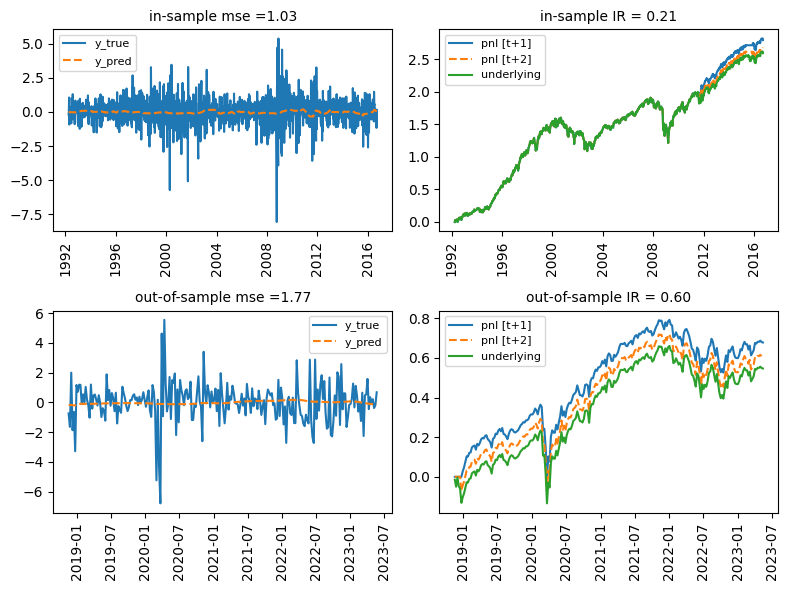

In [40]:
### Strategy Performance

# Use best thresholds
threshold = t1_max

plt.figure(figsize=(8, 6))

############## IS ##############

## MSE
plt.subplot(221)
y_pred = model.predict(eval_train)
y_true = np.concatenate([y for x, y in eval_train], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(train_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(train_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('in-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8}  )
plt.xticks(rotation=90)


## Performance
plt.subplot(222)

# Market
y_mkt = df1.iloc[lb+lf-1:,:].loc[:,'_MKT']

# Strategy
pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold, 1, 0)
pnl1_A = pos_A[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2_A = pos_A[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1_A))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2_A), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df1.iloc[lb+lf-1:,:].loc[:,'_TY'])  # treasury yield as risk-free
tmp_sr = pnl1_A - rf[:-1]
sr = tmp_sr.mean() / pnl1_A.std() * np.sqrt(52)
print("Sharpe Ratio IS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1_A - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('in-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8}  )
plt.xticks(rotation=90)


############## OOS ##############

## MSE
plt.subplot(223)
y_pred = model.predict(eval_test)
y_true = np.concatenate([y for x, y in eval_test], axis=0)
mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred))
plt.plot(test_df.index[lb+lf-1:], y_true[:, -1, -1])
plt.plot(test_df.index[lb+lf-1:], y_pred[:, -1], '--')
plt.title('out-of-sample mse =%1.2f' % mse, fontsize=10)
plt.legend(['y_true', 'y_pred'], prop={'size': 8}  )
plt.xticks(rotation=90)


## Performance
plt.subplot(224)

# Market
y_mkt = df2.iloc[lb+lf-1:,:].loc[:,'_MKT']

# Strategy A
pos_A = np.where(np.squeeze(y_pred[:, -1]) > threshold, 1, 0)
pnl1_A = pos_A[1:] * y_mkt[:-1]

# check robustness to implementation delay
pnl2_A = pos_A[2:] * y_mkt[:-2]
plt.plot(y_mkt.index[:-1], np.cumsum(pnl1_A))
plt.plot(y_mkt.index[:-2], np.cumsum(pnl2_A), '--')
plt.plot(y_mkt.index[:-1], np.cumsum(y_mkt[:-1]))

# Sharpe Ratio
rf = (df2.iloc[lb+lf-1:,:].loc[:,'_TY'])  # treasury yield as risk-free
tmp_sr = pnl1_A - rf[:-1]
sr = tmp_sr.mean() / pnl1_A.std() * np.sqrt(52)
print("Sharpe Ratio OOS: "+str(round(sr,2)))

# Information Ratio
tmp_ir = pnl1_A - y_mkt[:-1]
ir = tmp_ir.mean() / tmp_ir.std() * np.sqrt(52)

plt.title('out-of-sample IR = %1.2f' % ir, fontsize=10)
plt.legend(['pnl [t+1]', 'pnl [t+2]', 'underlying'], prop={'size': 8}  )
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



##### Distribution

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

Variable 1
1/1 [==============================] - 4s 4s/step


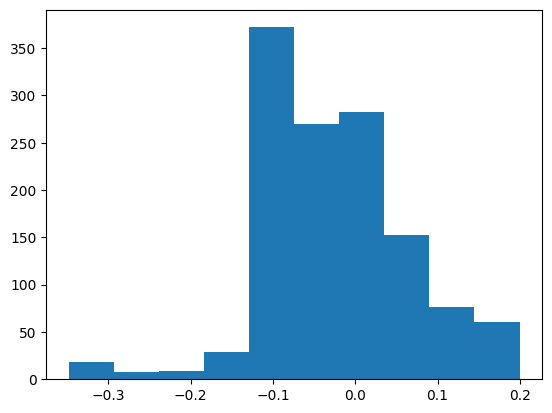

1/1 [==============================] - 2s 2s/step


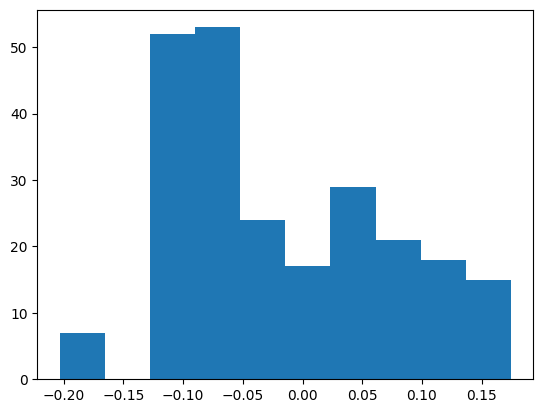

In [42]:
# When do we invest in market OOS
display(pos)

# Predicted values distribution
print("Variable 1")
y_pred = model.predict(eval_train)
n, bins, patches = plt.hist(np.squeeze(y_pred[:, -1]))
plt.show()
y_pred_t = model.predict(eval_test)
n, bins, patches = plt.hist(np.squeeze(y_pred_t[:, -1]))
plt.show()